In [1]:
from data import Data 

# Data class prefetches data
data = Data()

# data methods to comb
# X_train, y_train = data.get_aug_data()
X_train, y_train = data.get_train_data()
X_valid, y_valid = data.get_valid_data()
X_test, y_test = data.get_test_data()
print("X_train shape ", X_train.shape)
print("X_valid shape ", X_valid.shape)
print("X_test shape ", X_test.shape)
print("y_train shape ", y_train.shape)
print("y_valid shape ", y_valid.shape)
print("y_test shape ", y_test.shape)


X_train shape  (41471, 32, 32, 3)
X_valid shape  (5183, 32, 32, 3)
X_test shape  (10367, 32, 32, 3)
y_train shape  (41471,)
y_valid shape  (5183,)
y_test shape  (10367,)


In [2]:

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



In [3]:

def LeNet_Deeper(x):
    """ add fully connected layers:
        400 [-> 350 -> 300] -> 120 -> 84 -> 43
    """
    global conv1, conv2

    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = tf.compat.v1.layers.flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 350.
    fc1_W = tf.Variable(tf.random.truncated_normal(shape=(400, 350), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(350))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 3: Fully Connected. Input = 350. Output = 300.    
    fc2_W = tf.Variable(tf.random.truncated_normal(shape=(350, 300), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(300))
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 4: Fully Connected. Input = 300. Output = 120.    
    fc3_W = tf.Variable(tf.random.truncated_normal(shape=(300, 120), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(120))
    fc3   = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)

    # Layer 5: Fully Connected. Input = 120. Output = 84.
    fc4_W  = tf.Variable(tf.random.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(84))
    fc4    = tf.matmul(fc3, fc4_W) + fc4_b
    
    # Activation.
    fc4    = tf.nn.relu(fc4)

    # Layer 6: Fully Connected. Input = 84. Output = 43.
    fc5_W  = tf.Variable(tf.random.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc5_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc4, fc5_W) + fc5_b

    return logits


In [4]:

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
from sklearn.utils import shuffle

from lenet import LeNet, LeNet_Deeper_Wider, LeNet_Deepest_Widest

EPOCHS = 7 #15
BATCH_SIZE = 168

# x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.compat.v1.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

# List of different LeNet architectuture to test best performing
dnns = [LeNet, LeNet_Deeper, LeNet_Deeper_Wider, LeNet_Deepest_Widest]

for dnn in [dnns[1]]:
    logits = dnn(x)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)
    print("logits, one_hot_y ", logits, one_hot_y)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()

    num_examples = len(X_train)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
        
        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                
            validation_accuracy = evaluate(X_valid, y_valid)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            
        saver.save(sess, './' + dnn.__name__)
        print(dnn.__name__ + " Model saved")

        test_accuracy = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

        


Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

logits, one_hot_y  Tensor("add_6:0", shape=(None, 43), dtype=float32) Tensor("one_hot:0", dtype=float32)
Training...

EPOCH 1 ...
Validation Accuracy = 0.742

EPOCH 2 ...
Validation Accuracy = 0.876

EPOCH 3 ...
Validation Accuracy = 0.904

EPOCH 4 ...
Validation Accuracy = 0.923

EPOCH 5 ...
Validation Accuracy = 0.942

EPOCH 6 ...
Validation Accuracy = 0.928

EPOCH 7 ...
Validation Accuracy = 0.940

LeNet_Deeper Model saved
Test Accuracy = 0.943


In [5]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\LeNet_Deeper
Test Accuracy = 0.943


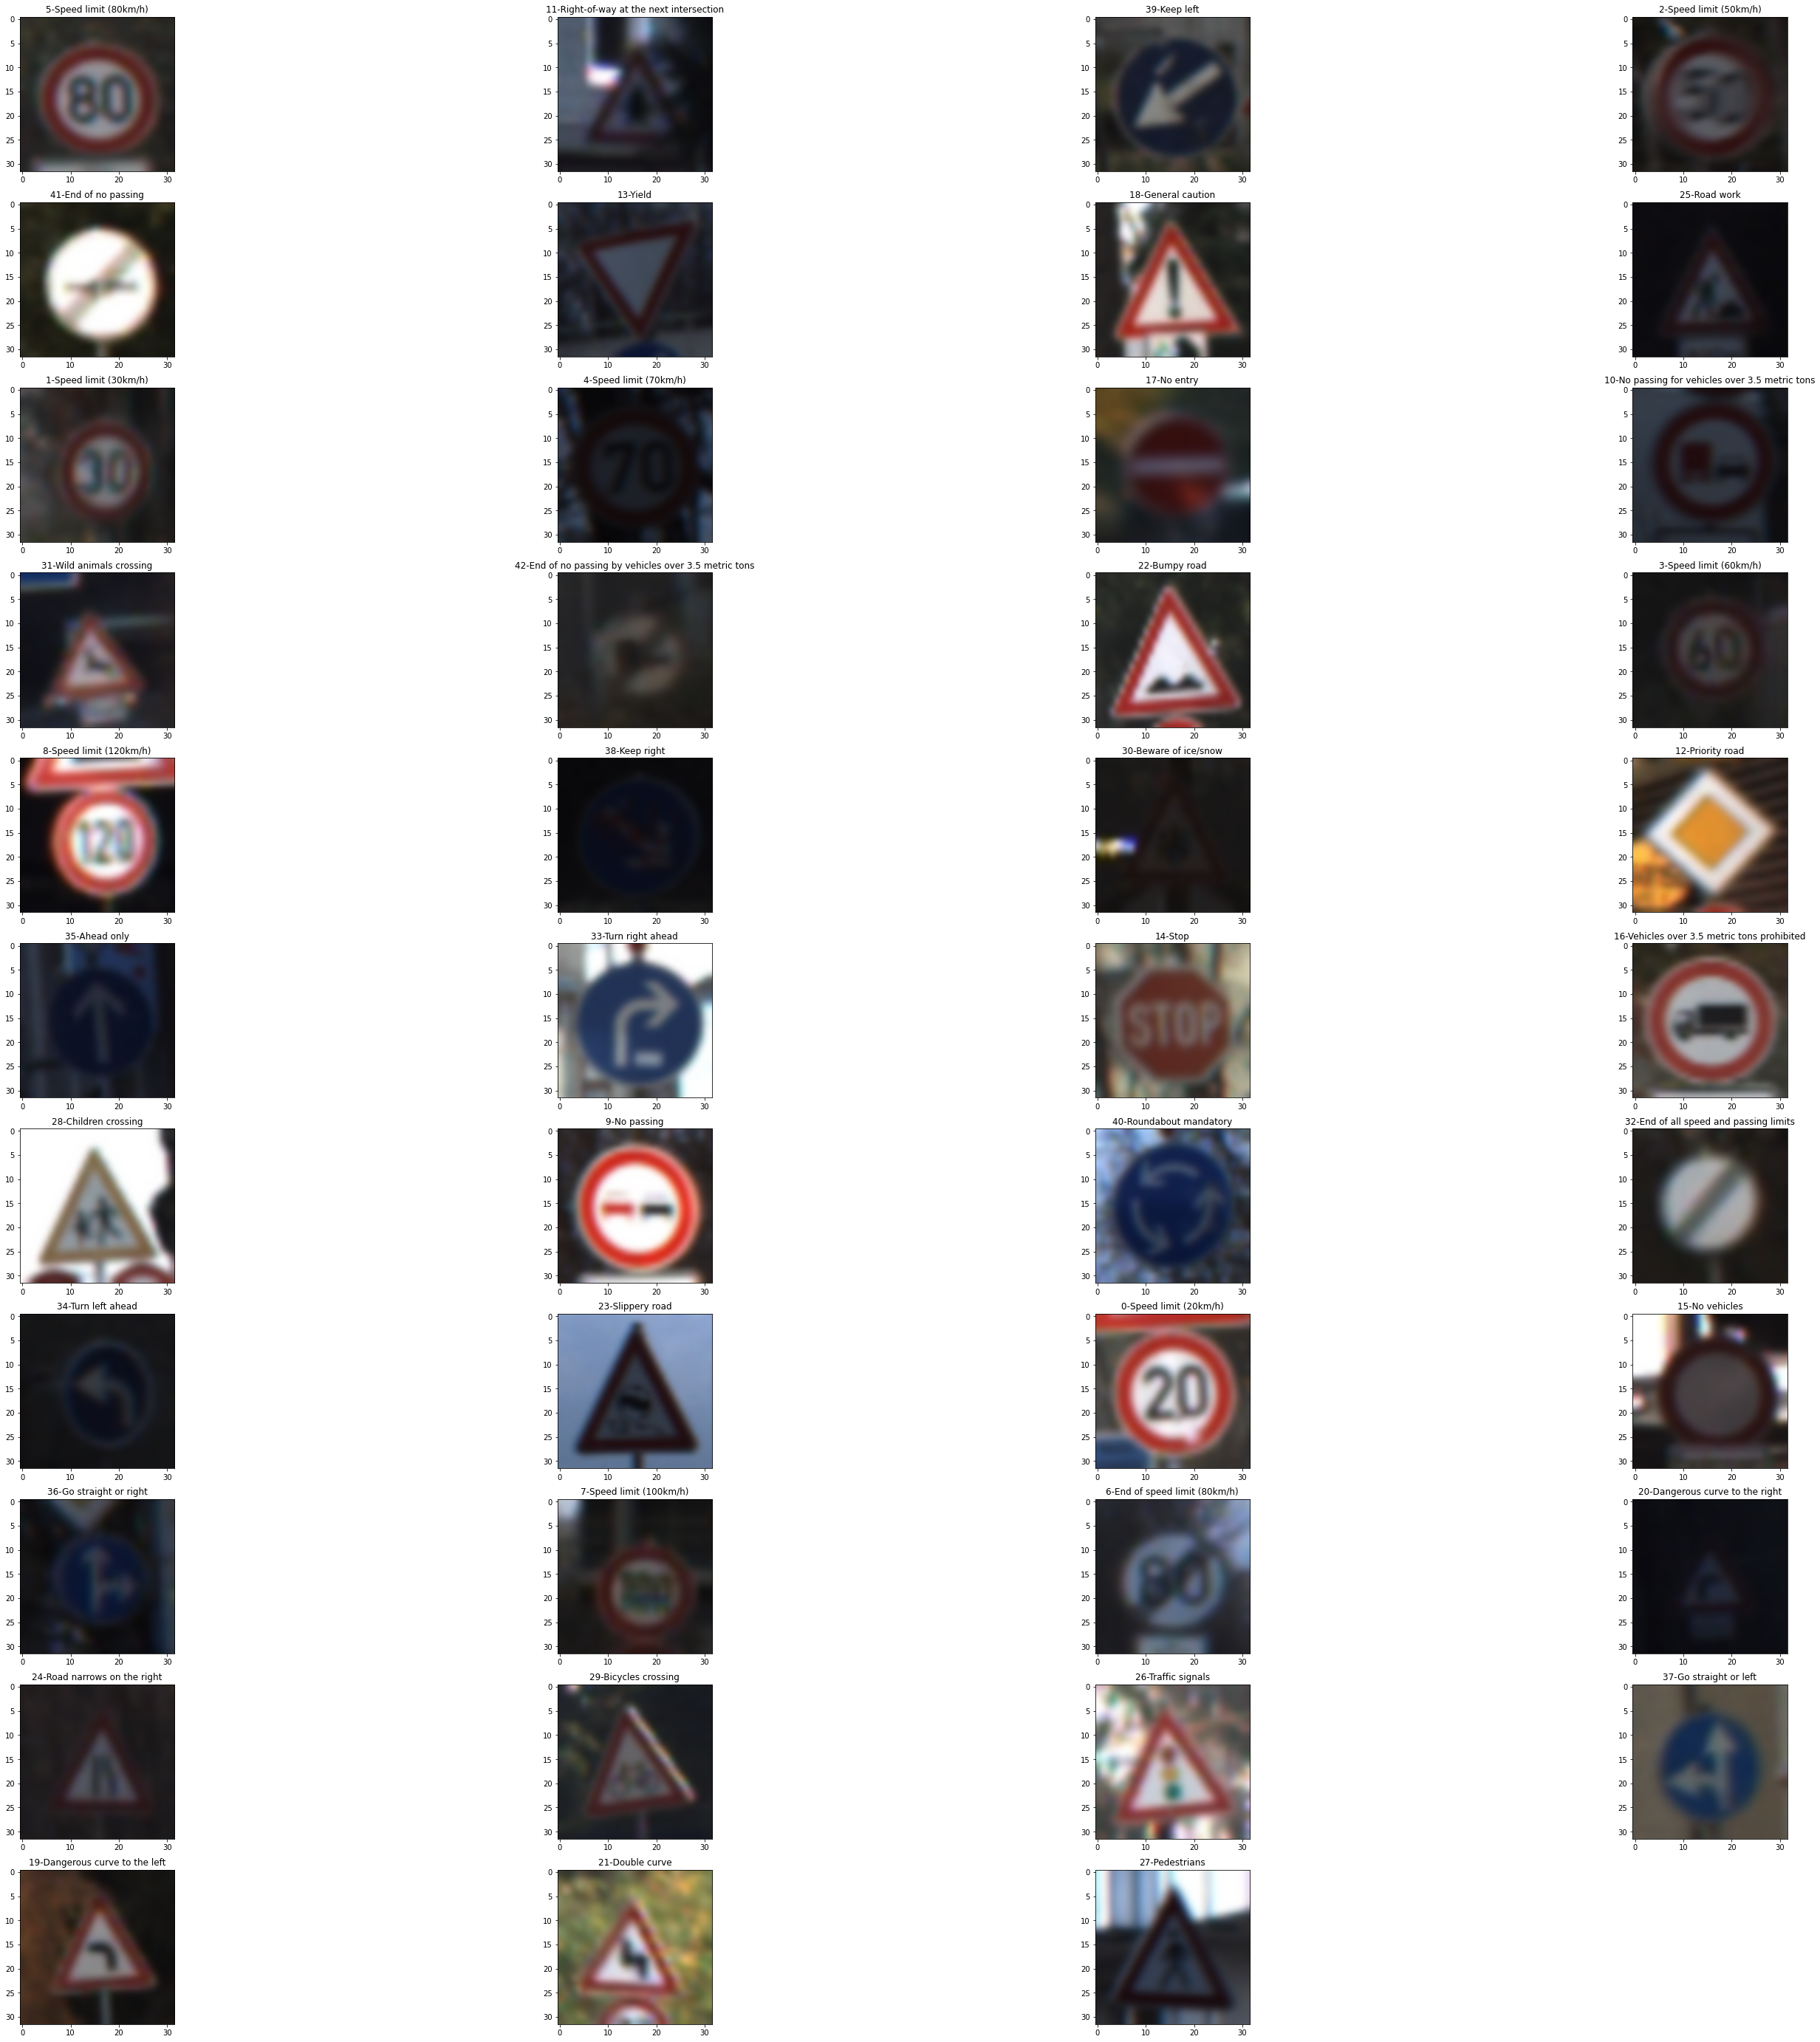

In [6]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
# show image of unique labels
import numpy as np
import csv 

signnames = {}
with open('signnames.csv', newline='') as csvfile:
    file = csv.reader(csvfile, delimiter=',')
    for row in file:
        signnames[row[0]] = row[1]

col = 11
row = 4
fig = plt.figure(figsize=(50,50))

unique = set(y_train)

j = 0
for i, label in enumerate(y_train):
    if not unique:
        break
    if label in unique:
        unique.remove(label)
        j += 1
        img = X_train[i]
        fig.add_subplot(col, row, j)
        plt.title("{0}-{1}".format(label, signnames[str(label)]))
        plt.imshow(img, interpolation="bicubic")

plt.show()

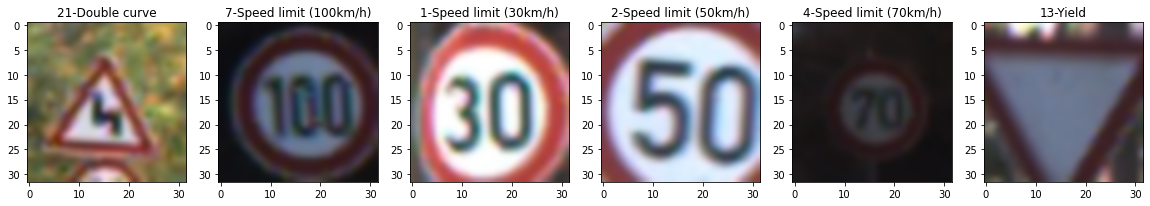

In [7]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import cv2 
import os 
from PIL import Image

path = './internet_signs'
files = os.listdir(path) 

dl_X_test = []
dl_y_test = []
names = []

for name in files:
    left = top = right = bottom = 0 

    # img = cv2.imread(os.path.join( path, name)) #Image.open(os.path.join( path, name))    
    img = Image.open(os.path.join( path, name))
    w, h = img.size #shape[:2] 
    dw = max(w - 32, 0)
    dh = max(h - 32, 0)
    crop_w = dw // 2 
    crop_h = dh // 2
    left = crop_w
    top = crop_h
    right = left + 32
    bottom =  top + 32
    # print(img.size)
    cropped = img.crop((left, top, right, bottom))
    # print(cropped.size)
    image_name, label = name.split('-')
    id = label.split('.')[0]
    dl_X_test.append(np.array(cropped))
    dl_y_test.append(id)

col = 1
row = 6
fig = plt.figure(figsize=(20,20))

for i, label in enumerate(dl_y_test):
    img = dl_X_test[i]
    # print(type(img))
    fig.add_subplot(col, row, i+1)
    plt.title("{0}-{1}".format(label, signnames[str(label)]))
    plt.imshow(img, interpolation="bicubic")
    names.append(signnames[str(label)])
plt.show()




In [8]:
prediction_operation = tf.argmax(logits, 1)
keep_prob = tf.placeholder(tf.float32)
def predict(X_data):
    num_examples = len(X_data)
    predictions = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        prediction = sess.run(prediction_operation, feed_dict={x: batch_x, keep_prob: 1.0})
        predictions.append(prediction)
    predictions = np.concatenate(predictions)

    return predictions


predicted_labels = []

print("Loading model...")
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Model loaded.")
    
    predicted_labels = predict(dl_X_test)

Loading model...
INFO:tensorflow:Restoring parameters from .\LeNet_Deeper
Model loaded.


In [9]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(dl_X_test, dl_y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

print("predicted", predicted_labels)
print("actual", dl_y_test)

INFO:tensorflow:Restoring parameters from .\LeNet_Deeper
Test Accuracy = 0.500
predicted [21  7 34 10  4 38]
actual ['21', '7', '1', '2', '4', '13']


In [10]:
softmax = tf.nn.softmax(logits)
top5_operation = tf.nn.top_k(softmax, 5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print()
    for j,image in  enumerate(dl_X_test):
        print("actual ", signnames[dl_y_test[j]])
        img = np.expand_dims(image, axis=0)
        top5_prediction = sess.run(top5_operation, feed_dict={x: img, keep_prob: 1.0})
        for i in range(5):
            print('{:s}: {:.5f}'.format(signnames[str(top5_prediction[1][0][i])], top5_prediction[0][0][i]))
        print()

INFO:tensorflow:Restoring parameters from .\LeNet_Deeper

actual  Double curve
Double curve: 1.00000
Right-of-way at the next intersection: 0.00000
Road narrows on the right: 0.00000
Pedestrians: 0.00000
Wild animals crossing: 0.00000

actual  Speed limit (100km/h)
Speed limit (100km/h): 0.91930
Speed limit (120km/h): 0.08047
Speed limit (80km/h): 0.00012
Ahead only: 0.00005
Roundabout mandatory: 0.00004

actual  Speed limit (30km/h)
Turn left ahead: 0.99986
Keep right: 0.00005
Yield: 0.00004
Right-of-way at the next intersection: 0.00003
Speed limit (30km/h): 0.00001

actual  Speed limit (50km/h)
No passing for vehicles over 3.5 metric tons: 0.92358
Turn left ahead: 0.07053
Ahead only: 0.00539
Dangerous curve to the right: 0.00031
Yield: 0.00018

actual  Speed limit (70km/h)
Speed limit (70km/h): 0.99996
Speed limit (30km/h): 0.00004
Speed limit (20km/h): 0.00000
Speed limit (80km/h): 0.00000
Speed limit (50km/h): 0.00000

actual  Yield
Keep right: 0.82048
Yield: 0.16942
Priority road

Loading model...
INFO:tensorflow:Restoring parameters from .\LeNet_Deeper
Model loaded.

Speed limit (50km/h)


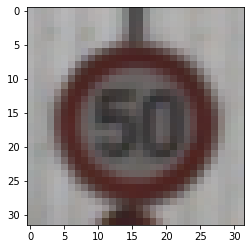

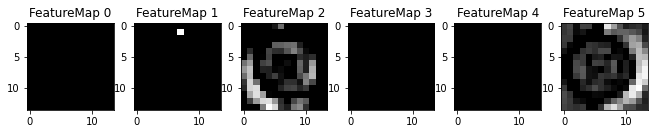

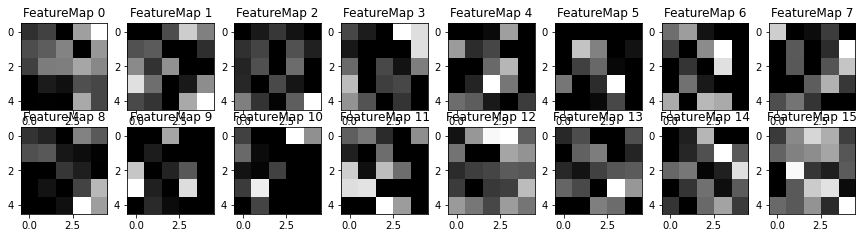

In [11]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

print("Loading model...")
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Model loaded.")

    print()
    index = np.random.randint(0, len(y_train))
    print(signnames[str(y_train[index])])
    img = X_train[index]
    plt.imshow(img, vmin=-1, vmax=1)
    plt.show()
    img = np.expand_dims(img, axis=0)
    outputFeatureMap(img, conv1, plt_num=1)
    outputFeatureMap(img, conv2, plt_num=2)

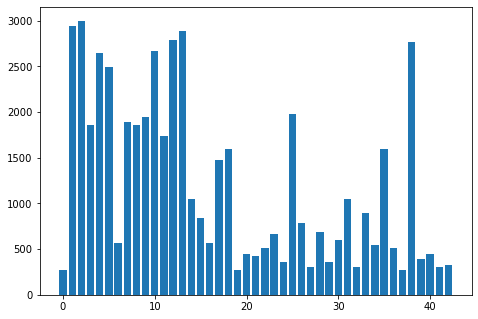

In [12]:
# whole dataset count of each sign class
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
signs = []
counts = []
for id, imgs in data.img_id_dict.items():
    signs.append(id) 
    counts.append(len(imgs)) 
    
ax.bar(signs,counts)
plt.show()

43 43 43


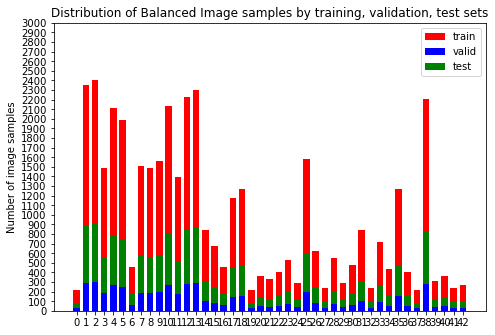

In [13]:
# whole dataset count of each sign class proportioned by X, valid, test

import numpy as np
import matplotlib.pyplot as plt

# extract count at respective index
train, valid, test = data.get_rebalanced_train_valid_test_counts()
ind = np.arange(data.num_sign_types) # the x locations for the groups
width = 0.7
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# print(ind, train, width)
print(len(train),len(valid),len(test)) 

ax.bar(ind, train, width, color='r')
ax.bar(ind, valid, width, color='b')
ax.bar(ind, test, width,bottom=valid, color='g')
ax.set_ylabel('Number of image samples')
ax.set_title('Distribution of Balanced Image samples by training, validation, test sets')
ax.set_xticks(ind)
ax.set_yticks(np.arange(0, max(counts)+100, 100))
ax.legend(labels=["train", "valid", "test"])
plt.show()


43 43 43


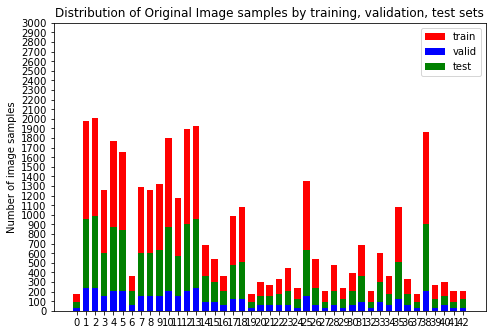

In [14]:
# extract count at respective index
train, valid, test = data.get_original_train_valid_test_counts()
ind = np.arange(data.num_sign_types) # the x locations for the groups
width = 0.7
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# print(ind, train, width)
print(len(train),len(valid),len(test)) 

ax.bar(ind, train, width, color='r')
ax.bar(ind, valid, width, color='b')
ax.bar(ind, test, width,bottom=valid, color='g')
ax.set_ylabel('Number of image samples')
ax.set_title('Distribution of Original Image samples by training, validation, test sets')
ax.set_xticks(ind)
ax.set_yticks(np.arange(0, max(counts)+100, 100))
ax.legend(labels=["train", "valid", "test"])
plt.show()
